# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn. metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers
import joblib


# Data load and display

In [2]:
dtf = pd.read_csv("credit_risk_dataset.csv")
dtf


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


# Understanding the data

([<matplotlib.patches.Wedge at 0x156bbc1e0d0>,
 [Text(-0.8515948201410832, 0.6962659422296026, '0'),
  Text(0.8515948201410835, -0.6962659422296024, '1')],
 [Text(-0.4645062655314999, 0.37978142303432866, '78.2%'),
  Text(0.4645062655315, -0.3797814230343285, '21.8%')])

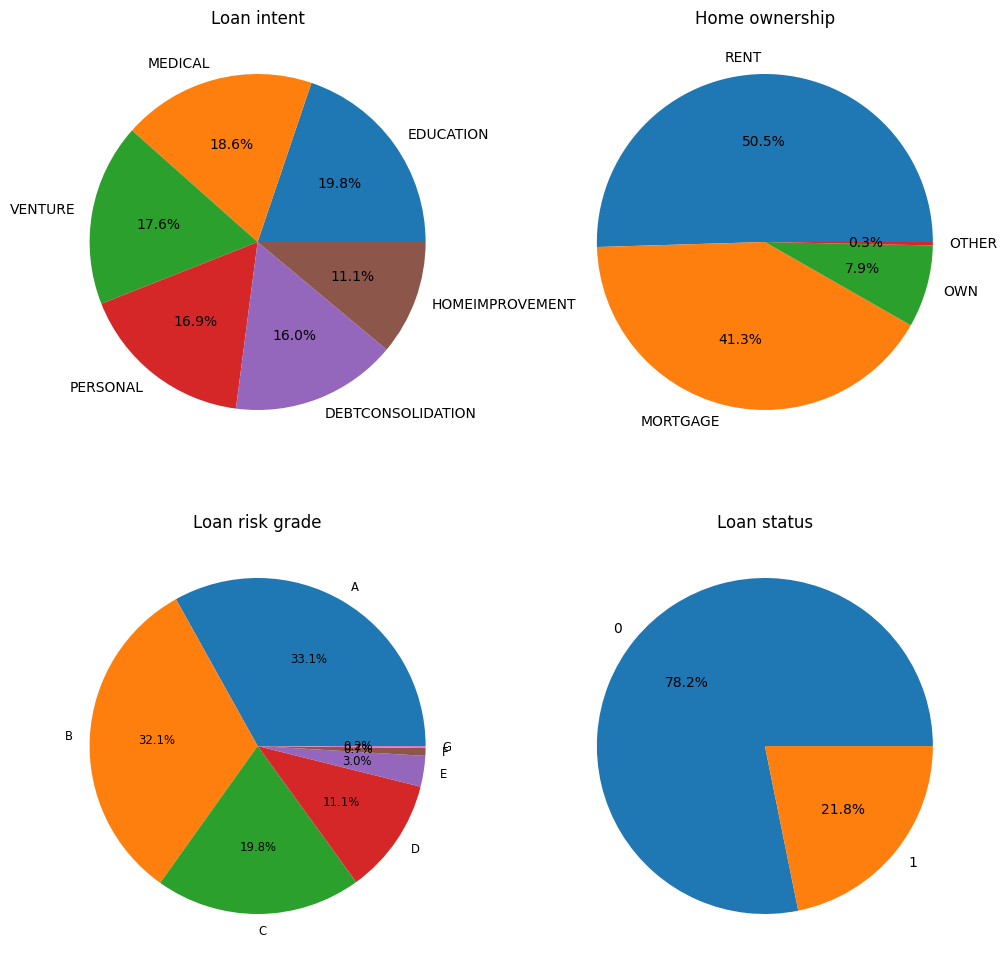

In [3]:
fig,ax = plt.subplots(2,2, figsize=(12,12))
def basicPlot(ax):
    
    ax[0,0].set_title("Loan intent")
    ax[0,0].pie(dtf["loan_intent"].value_counts(), labels=dtf["loan_intent"].value_counts().index, autopct="%1.1f%%")
    ax[0,1].set_title("Home ownership")
    ax[0,1].pie(dtf["person_home_ownership"].value_counts(), labels=dtf["person_home_ownership"].value_counts().index, autopct="%1.1f%%")
    ax[1,0].set_title("Loan risk grade")
    ax[1,0].pie(dtf["loan_grade"].value_counts(), labels=dtf["loan_grade"].value_counts().index, textprops={'size': 'smaller'}, autopct="%1.1f%%")

basicPlot(ax)
ax[1,1].set_title("Loan status")
ax[1,1].pie(dtf["loan_status"].value_counts(), labels=dtf["loan_status"].value_counts().index, autopct="%1.1f%%")




## Missing values

In [4]:
duplicates = dtf.duplicated().sum()
print(duplicates)
dtf.drop_duplicates(inplace=True)
missing = dtf.isna().sum()
print(missing)
all= dtf.count()
height = missing/all
ax[1,1].set_title("Missing values per column")
ax[1,1].bar(height=height[height!=0], x=height[height!=0].index)

ax[1,1].tick_params(axis="x", labelsize=10)



165
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


## Changes after deleting missing values

([<matplotlib.patches.Wedge at 0x156bbda30d0>,
 [Text(-0.8538843289352632, 0.6934562371186631, '0'),
  Text(0.8538843938613183, -0.6934561571722392, '1')],
 [Text(-0.46575508851014347, 0.3782488566101798, '78.3%'),
  Text(0.46575512392435536, -0.37824881300303953, '21.7%')])

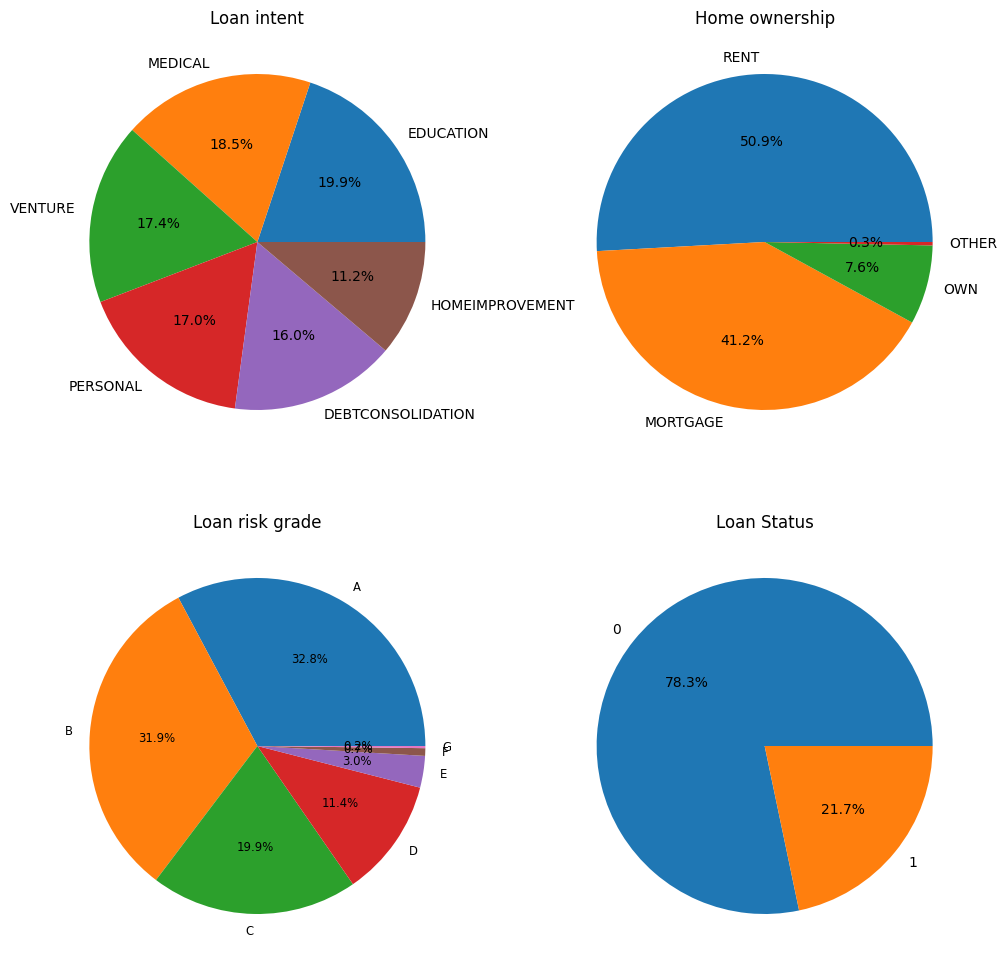

In [5]:
dtf.dropna(inplace=True)
fig,ax = plt.subplots(2,2, figsize=(12,12))
basicPlot(ax)
ax[1,1].set_title("Loan Status")
ax[1,1].pie(dtf["loan_status"].value_counts(), labels=dtf["loan_status"].value_counts().index, autopct="%1.1f%%")





# Data Encodings

In [6]:
lb = LabelEncoder()
dtf["loan_grade"] = lb.fit_transform(dtf["loan_grade"])
joblib.dump(lb, "lb_loan_grade.joblib")


mapped_grade = dict(zip(lb.classes_, range(len(lb.classes_))))

dtf["loan_intent"] = lb.fit_transform(dtf["loan_intent"])

joblib.dump(lb, "lb_loan_intent.joblib")
dtf["person_home_ownership"] = lb.fit_transform(dtf["person_home_ownership"])

joblib.dump(lb, "lb_home_owner.joblib")

dtf["cb_person_default_on_file"] = dtf["cb_person_default_on_file"].apply(lambda x: 1 if str(x).strip().upper()=='Y' else 0)



dtf


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,3,123.0,4,3,35000,16.02,1,0.59,1,3
1,21,9600,2,5.0,1,1,1000,11.14,0,0.10,0,2
2,25,9600,0,1.0,3,2,5500,12.87,1,0.57,0,3
3,23,65500,3,4.0,3,2,35000,15.23,1,0.53,0,2
4,24,54400,3,8.0,3,2,35000,14.27,1,0.55,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,0,1.0,4,2,5800,13.16,0,0.11,0,30
32577,54,120000,0,4.0,4,0,17625,7.49,0,0.15,0,19
32578,65,76000,3,3.0,2,1,35000,10.99,1,0.46,0,28
32579,56,150000,0,5.0,4,1,15000,11.48,0,0.10,0,26


# Correlation heatmap

<Axes: title={'center': 'Correlation heatmap'}>

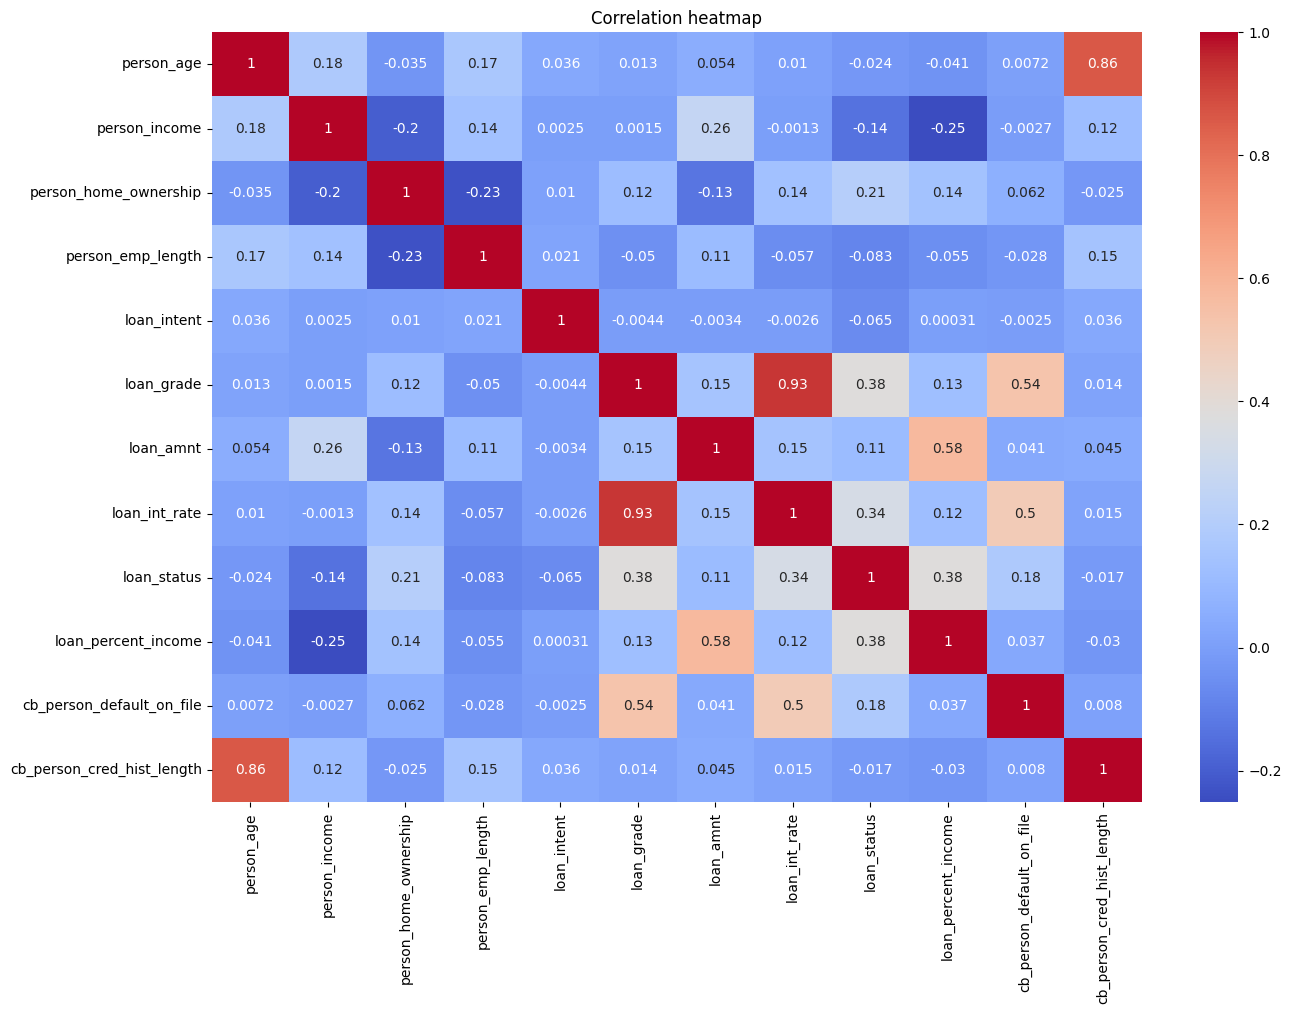

In [7]:
plt.figure(figsize=(15,10))
plt.title("Correlation heatmap")
sns.heatmap(data=dtf.corr(),annot=True, cmap="coolwarm")

## Scaling

In [8]:
mapped_classes = {
                    "Not approved for loan" : 0,
                    "Approved for loan" : 1
}

sc = StandardScaler()
dtf[["person_age", "person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]] = sc.fit_transform(dtf[["person_age", "person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]])
joblib.dump(sc, "scaler.joblib")
dtf

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,-0.908585,-0.122716,3,28.433679,4,3,4.003712,1.539799,1,3.951599,1,-0.692835
1,-1.066912,-0.914701,2,0.050477,1,1,-1.367966,0.029286,0,-0.653299,0,-0.940233
2,-0.433605,-0.914701,0,-0.911665,3,2,-0.657009,0.564775,1,3.763644,0,-0.692835
3,-0.750259,-0.018508,3,-0.190059,3,2,4.003712,1.295269,1,3.387734,0,-0.940233
4,-0.591932,-0.196464,3,0.772084,3,2,4.003712,0.998119,1,3.575689,1,-0.445438
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,4.632848,-0.218909,0,-0.911665,4,2,-0.609612,0.654540,0,-0.559321,0,5.986890
32577,4.157868,0.855241,0,-0.190059,4,0,1.258626,-1.100503,0,-0.183411,0,3.265520
32578,5.899461,0.149829,3,-0.430594,2,1,4.003712,-0.017143,1,2.729891,0,5.492095
32579,4.474521,1.336203,0,0.050477,4,1,0.843901,0.134527,0,-0.653299,0,4.997301


# Model selection and training
*Disclaimer*: I used **.predict_proba** instead of **.predict** because of the ROC AUC score

In [9]:
def ROC_Curve_plot (y_test, y_pred_proba, modelName):
    fpr, tpr, tresholds =roc_curve(y_test,y_pred_proba)

    roc_auc = auc(fpr,tpr)

    plt.figure(figsize=(10,7))
    plt.plot(fpr,tpr, color='red', lw=2, label=f"{modelName} (AUC ={roc_auc:.4f})")
    plt.plot([0,1],[0,1], color='navy', linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

def Evaluate_metrics (y_test, y_pred, y_pred_proba, model,mapped_classes):
    if (y_pred_proba !=[]):
        roc_auc = roc_auc_score(y_test,y_pred_proba)
        score = f"ROC AUC Score: {roc_auc}"

    else:
        score=""

    accuracy = accuracy_score(y_test,y_pred)
    class_report = classification_report(y_test,y_pred, labels=model.classes_)
    cm =confusion_matrix(y_test,y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mapped_classes.keys())
    disp.plot()

    print(score)
    print(f"Accuracy score:{accuracy}")
    print(f"Class report:{class_report}")


### Logistic regression without tuning
With SMOTE balance the score improved significantly (**over 10%**)

(28501, 11) (28501,)


C:\Users\Dogo\AppData\Local\Temp\ipykernel_62740\3269707892.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (y_pred_proba !=[]):


ROC AUC Score: 0.8528540041612107
Accuracy score:0.7792964373739637
Class report:              precision    recall  f1-score   support

           0       0.78      0.79      0.78      4496
           1       0.78      0.77      0.78      4430

    accuracy                           0.78      8926
   macro avg       0.78      0.78      0.78      8926
weighted avg       0.78      0.78      0.78      8926



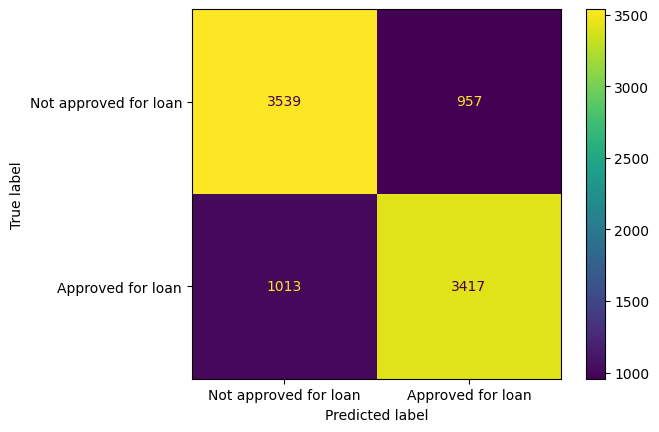

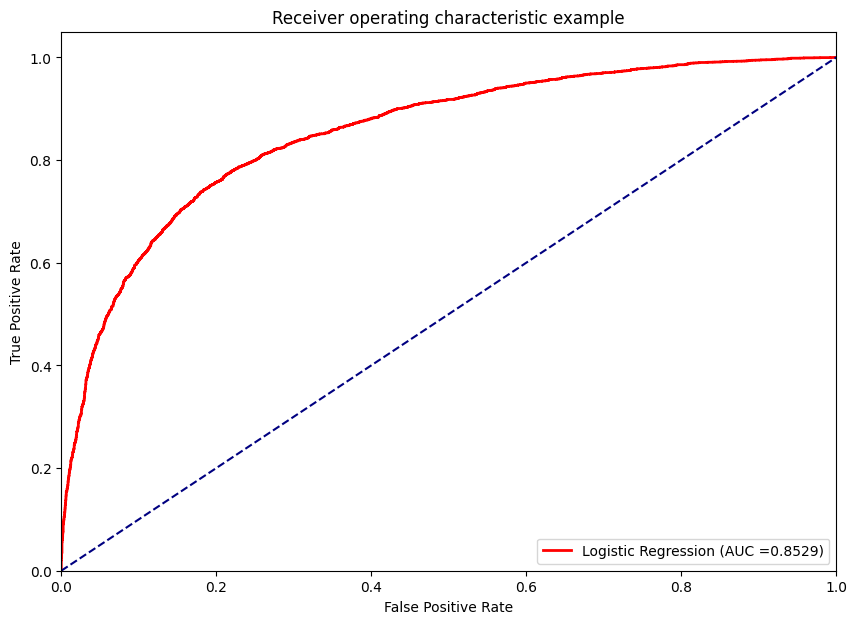

In [28]:
#X = dtf[["loan_grade","loan_int_rate","loan_percent_income","person_home_ownership"]]
X = dtf.drop(columns="loan_status")
y = dtf["loan_status"]
print(X.shape,y.shape)

from imblearn.over_sampling import SMOTE 

smote= SMOTE(random_state=42)
X_refitted,y_refitted = smote.fit_resample(X,y)
X_train,X_test,y_train,y_test = train_test_split(X_refitted,y_refitted, test_size=0.2, random_state=42)

linReg = LogisticRegression()

linReg.fit(X_train,y_train)
y_pred_proba = linReg.predict_proba(X_test)[:,1]
y_pred = linReg.predict(X_test)

Evaluate_metrics(y_test,y_pred,y_pred_proba, linReg, mapped_classes)
ROC_Curve_plot(y_test,y_pred_proba,"Logistic Regression")




### Logistic regression with Grid Search tuning
 With SMOTE balance score improved **insignificantly** but greater runtime

In [11]:
parameter_grid = [{"penalty":["l2","none"],"C":np.logspace(-4,4,20),"solver":["lbfgs","newton-cg","sag"],"max_iter": [100,1000,2500,5000]},
                  {"penalty":["l1","l2"],"C":np.logspace(-4,4,20),"solver":["liblinear"],"max_iter": [100,1000,2500,5000]},
                  {"penalty":["l1","l2","elasticnet"],"C":np.logspace(-4,4,20),"solver":["saga",], "l1_ratio":[0.5],"max_iter": [100,1000,2500,5000]}]


X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)
clf = GridSearchCV(estimator=linReg,param_grid=parameter_grid, cv=5, n_jobs=-1, verbose=True, scoring="roc_auc") 
clf.fit(X_train,y_train)



Fitting 5 folds for each of 880 candidates, totalling 4400 fits


C:\Users\Dogo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1200 fits failed out of a total of 4400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
84 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dogo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dogo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-pac

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'l1_ratio': [0.5],
                          'max_iter': [100, 1000, 2500, 5000],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['saga']}],
             scoring='roc_auc', verbose=True)

C:\Users\Dogo\AppData\Local\Temp\ipykernel_62740\3269707892.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (y_pred_proba !=[]):


ROC AUC Score: 0.8490821458058567
Accuracy score:0.8421329591299772
Class report:              precision    recall  f1-score   support

           0       0.86      0.96      0.90      4441
           1       0.74      0.44      0.55      1260

    accuracy                           0.84      5701
   macro avg       0.80      0.70      0.73      5701
weighted avg       0.83      0.84      0.83      5701



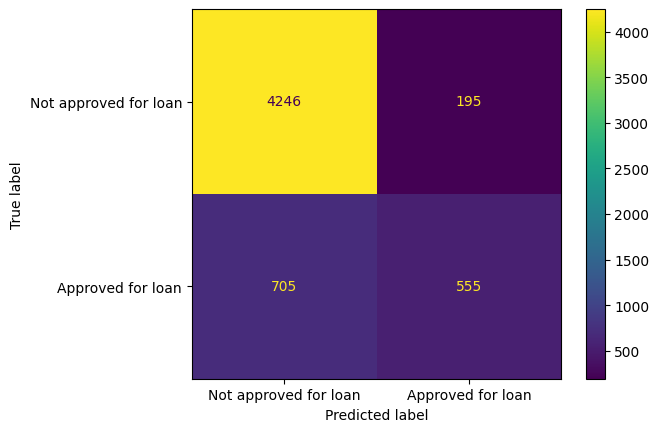

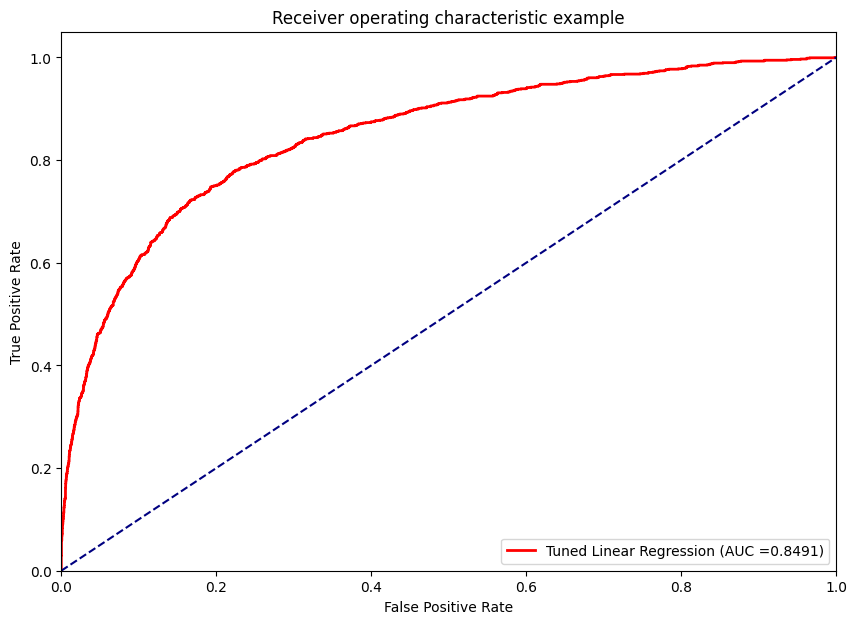

In [12]:
model = clf.best_estimator_

linReg.fit(X_train,y_train)

y_pred = linReg.predict(X_test)
y_pred_proba= linReg.predict_proba(X_test)[:,1]

Evaluate_metrics(y_test,y_pred,y_pred_proba, linReg,mapped_classes)
ROC_Curve_plot(y_test,y_pred_proba,"Tuned Linear Regression")

### Random Forest Classifier without tuning

C:\Users\Dogo\AppData\Local\Temp\ipykernel_62740\3269707892.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (y_pred_proba !=[]):


ROC AUC Score: 0.9333298523092581
Accuracy score:0.9307139098403788
Class report:              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4463
           1       0.96      0.71      0.82      1238

    accuracy                           0.93      5701
   macro avg       0.94      0.85      0.89      5701
weighted avg       0.93      0.93      0.93      5701



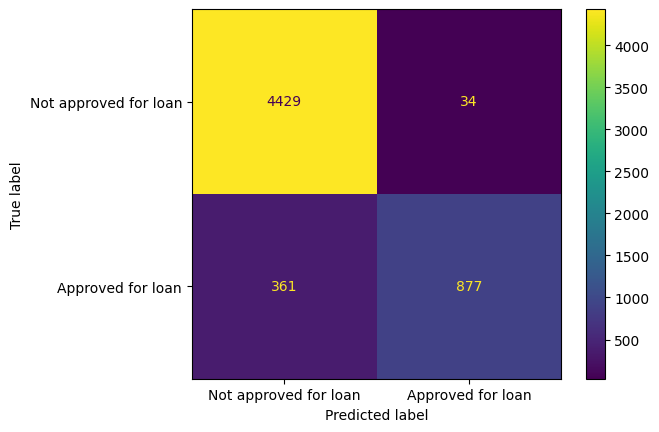

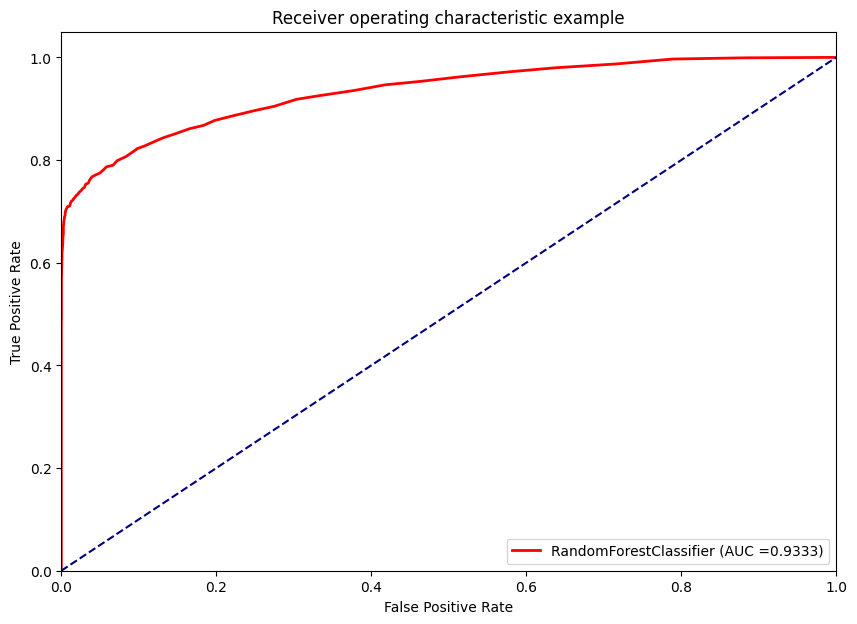

In [13]:
rf = RandomForestClassifier(random_state=42)

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

rf.fit(X_train,y_train)
y_pred= rf.predict(X_test)
y_pred_proba= rf.predict_proba(X_test)[:,1]

Evaluate_metrics(y_test,y_pred,y_pred_proba, rf,mapped_classes)
ROC_Curve_plot(y_test,y_pred_proba,"RandomForestClassifier")



### Random Forest Classifier with Grid Search tuning

In [14]:
parameter_grid = {"n_estimators": [100,200,300],
                  "max_depth": [10,20,30],
                  "min_samples_split": [2,5,10],
                  "min_samples_leaf": [1,2,4],
                  "bootstrap":[True,False]

}

clf = GridSearchCV(estimator=rf,param_grid=parameter_grid,cv=5, n_jobs=-1, verbose=True, scoring="roc_auc")

clf.fit(X_train,y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=True)

ROC AUC Score: 0.9386217026949641
Accuracy score:0.9291352394316786
Class report:              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4463
           1       0.95      0.71      0.81      1238

    accuracy                           0.93      5701
   macro avg       0.94      0.85      0.88      5701
weighted avg       0.93      0.93      0.93      5701



C:\Users\Dogo\AppData\Local\Temp\ipykernel_62740\3269707892.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (y_pred_proba !=[]):


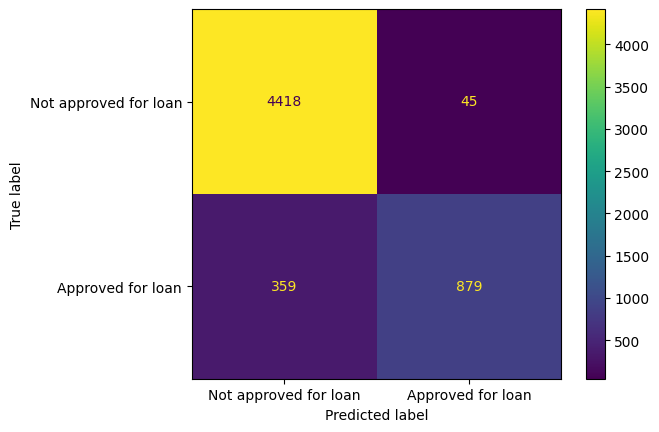

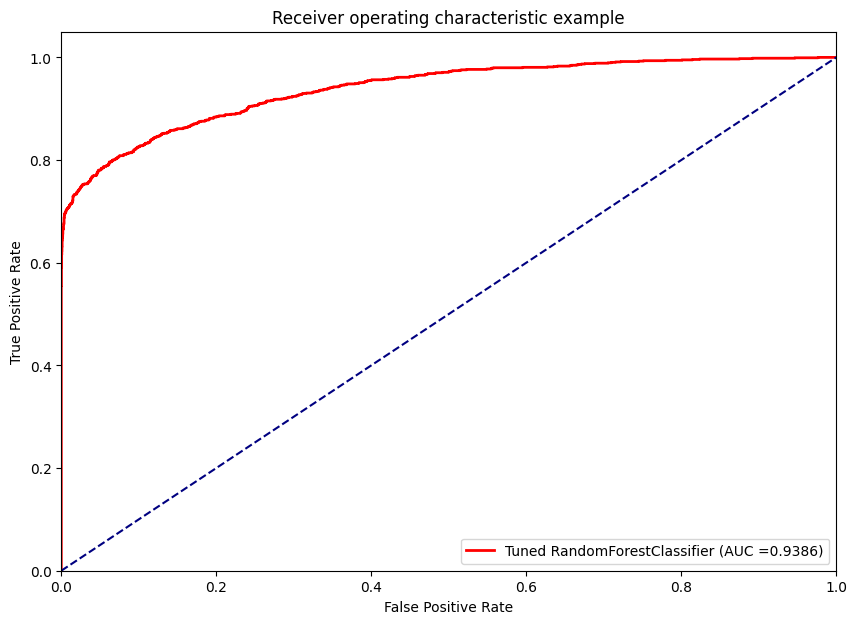

In [15]:
rf = clf.best_estimator_
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)
y_pred_proba= rf.predict_proba(X_test)[:,1]

Evaluate_metrics(y_test,y_pred,y_pred_proba, rf,mapped_classes)
ROC_Curve_plot(y_test,y_pred_proba,"Tuned RandomForestClassifier")



### Extreme Gradient booster with some tuning

ROC AUC Score: 0.9480179338499245
Accuracy score:0.932643395895457
Class report:              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4463
           1       0.96      0.72      0.82      1238

    accuracy                           0.93      5701
   macro avg       0.95      0.85      0.89      5701
weighted avg       0.93      0.93      0.93      5701



C:\Users\Dogo\AppData\Local\Temp\ipykernel_62740\3269707892.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (y_pred_proba !=[]):


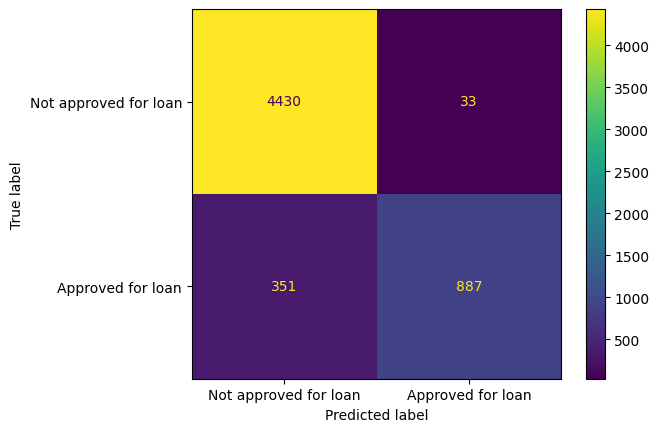

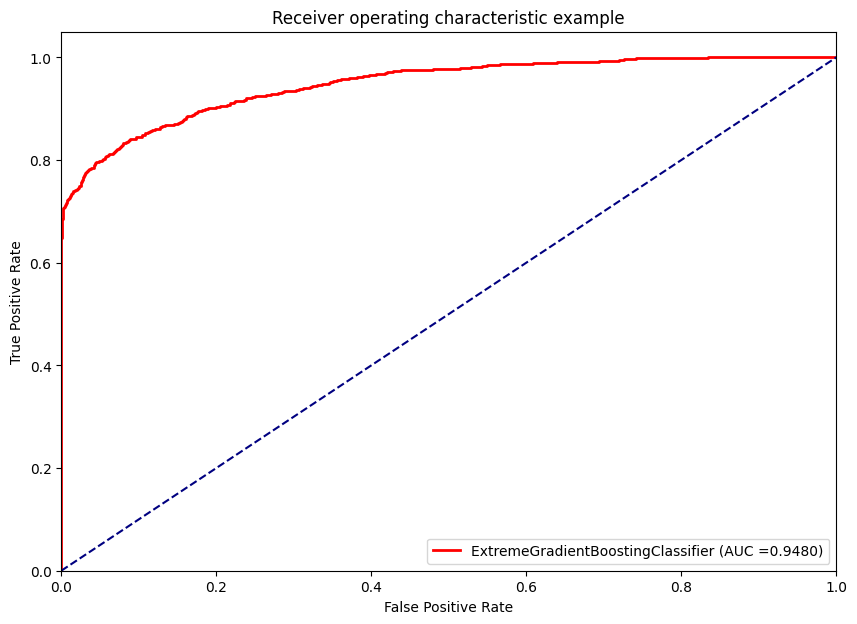

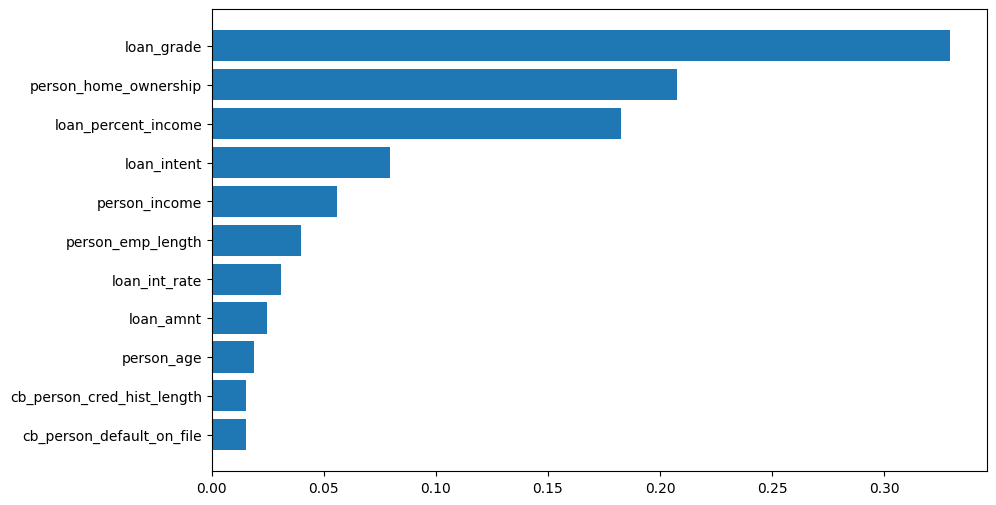

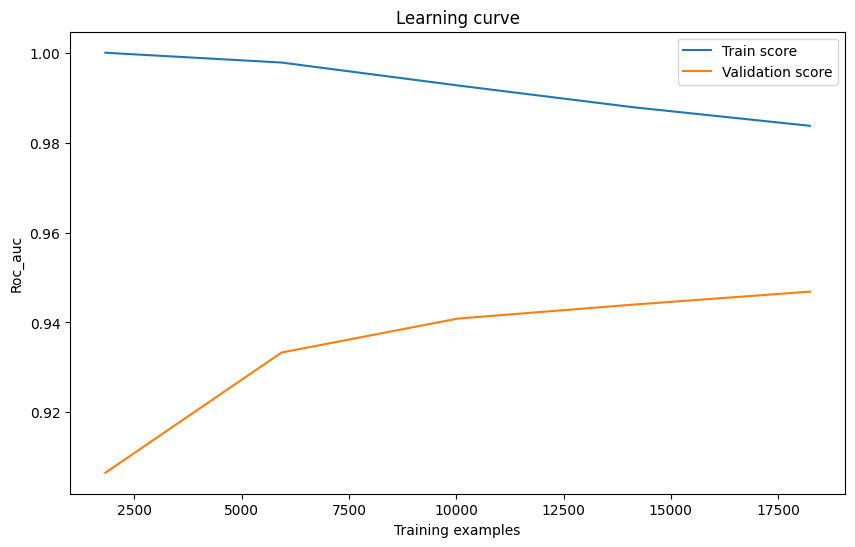

In [59]:
xg = xgb.XGBClassifier(objective="binary:logistic",eval_metric="auc", n_estimators=350, max_depth=5, learning_rate=0.07, subsample=0.85, colsample_bytree=0.9,verbosity=2, seed=42)
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
xg.fit(X_train,y_train)

y_pred = xg.predict(X_test)
y_pred_proba= xg.predict_proba(X_test)[:,1]

Evaluate_metrics(y_test,y_pred,y_pred_proba,xg,mapped_classes)
ROC_Curve_plot(y_test,y_pred_proba,"ExtremeGradientBoostingClassifier")

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    xg, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

feature_importance = xg.feature_importances_
importance_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_idx)),feature_importance[importance_idx])
plt.yticks(range(len(importance_idx)), np.array(X_test.columns)[importance_idx])
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Train score")
plt.plot(train_sizes, test_scores_mean, label="Validation score")
plt.xlabel("Training examples")
plt.ylabel("Roc_auc")
plt.legend()
plt.title("Learning curve")
plt.show()



## Finding the best treshold for the model

In [17]:
tresholds = np.arange(0,1, 0.01)
f1_scores = []

for treshold in tresholds:
    y_pred = (y_pred_proba >=treshold)
    f1 = f1_score(y_test,y_pred)
    f1_scores.append(f1)

best_treshold = tresholds[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f"Best treshold: {best_treshold}")
print(f"Best f1 score: {best_f1_score}")


Best treshold: 0.54
Best f1 score: 0.8265682656826568


### F1 score vs Treshold

C:\Users\Dogo\AppData\Local\Temp\ipykernel_62740\651269494.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


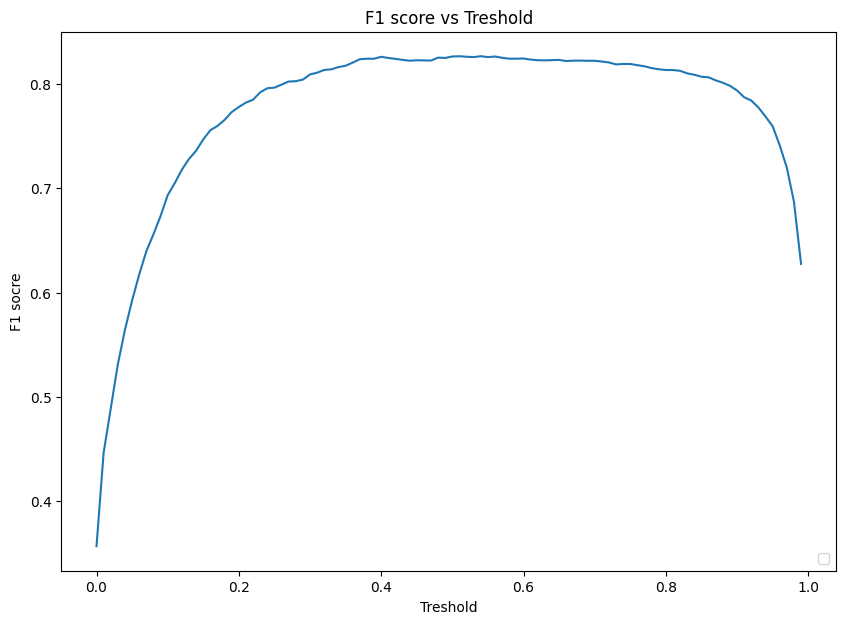

In [18]:
plt.figure(figsize=(10,7))
plt.plot(tresholds,f1_scores)
plt.xlabel("Treshold")
plt.ylabel("F1 socre")
plt.title("F1 score vs Treshold")
plt.legend(loc="lower right")
plt.show()

### Gradient booster with Grid search tuning

In [19]:

parameter_grid = {"n_estimators": [100,150,200],
                  "max_depth":[3,5,7],
                  "learning_rate":[0.002,0.01, 0.2],
                  "subsample":[0.7,1.0],
                  "colsample_bytree":[0.7,1.0],
                  "gamma": [0,0.1,0.2],
                  "device":["cuda"]}

clf = GridSearchCV(estimator=xg, param_grid=parameter_grid, n_jobs=-1, verbose=True, scoring="roc_auc", cv=5)

clf.fit(X_train,y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1.0], 'device': ['cuda'],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.002, 0.01, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 150, 200],
                         'subsample': [0.7, 1.0]},
             scoring='roc_auc', verbose=True)

C:\Users\Dogo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [13:54:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
C:\Users\Dogo\AppData\Local\Temp\ipykernel_62740\3269707892.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (y_pred_proba !=[]):


ROC AUC Score: 0.9461050598404327
Accuracy score:0.9328188037186459
Class report:              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4463
           1       0.96      0.72      0.82      1238

    accuracy                           0.93      5701
   macro avg       0.94      0.86      0.89      5701
weighted avg       0.93      0.93      0.93      5701



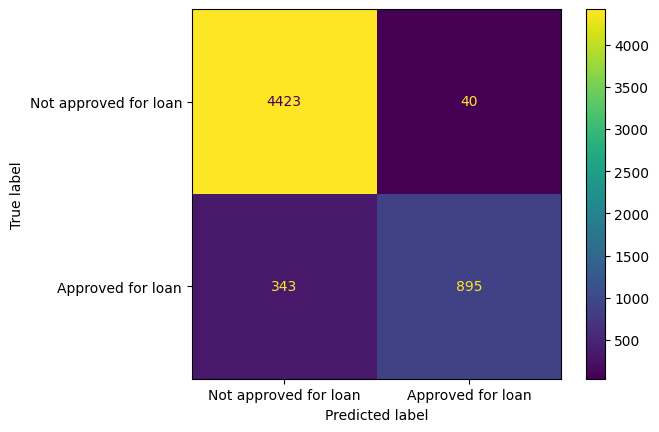

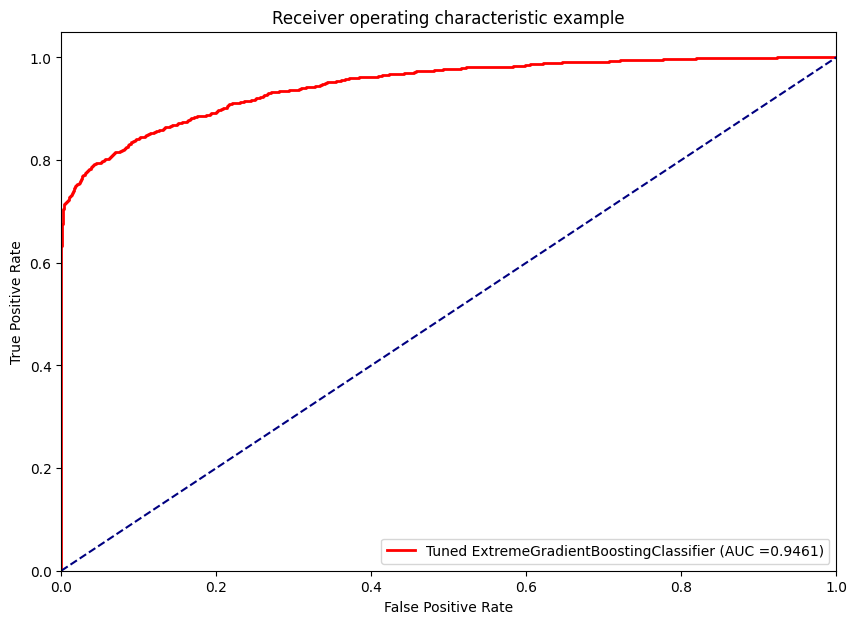

In [20]:
xg = clf.best_estimator_
xg.fit(X_train,y_train)

y_pred = xg.predict(X_test)
y_pred_proba= xg.predict_proba(X_test)[:,1]

Evaluate_metrics(y_test,y_pred,y_pred_proba, xg,mapped_classes)
ROC_Curve_plot(y_test,y_pred_proba,"Tuned ExtremeGradientBoostingClassifier")

### Model testing with K fold validation

In [21]:
kfold = StratifiedKFold(n_splits=10,random_state=42,shuffle=True)
ROC_scores =[]
accuracy_scores = []

for fold, (train_index, test_index) in enumerate (kfold.split(X,y)):
    X_train,X_test = X.iloc[train_index],X.iloc[test_index]
    y_train,y_test = y.iloc[train_index],y.iloc[test_index]

    xg.fit(X_train,y_train)

    y_pred= xg.predict(X_test)
    y_pred_proba = xg.predict_proba(X_test)[:,1]

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test,y_pred)

    ROC_scores.append(roc_auc)
    accuracy_scores.append(accuracy)

    print(f"Fold {fold}: ROC socre = {roc_auc:.4f}, Accuracy = {accuracy:.4f}")

print(f"Average ROC AUC Score: {np.mean(ROC_scores):.4f}")
print(f"Average accuracy Score: {np.mean(accuracy_scores):.4f}")



Fold 0: ROC socre = 0.9561, Accuracy = 0.9400
Fold 1: ROC socre = 0.9528, Accuracy = 0.9344
Fold 2: ROC socre = 0.9468, Accuracy = 0.9344
Fold 3: ROC socre = 0.9478, Accuracy = 0.9323
Fold 4: ROC socre = 0.9445, Accuracy = 0.9365
Fold 5: ROC socre = 0.9482, Accuracy = 0.9337
Fold 6: ROC socre = 0.9464, Accuracy = 0.9389
Fold 7: ROC socre = 0.9467, Accuracy = 0.9337
Fold 8: ROC socre = 0.9514, Accuracy = 0.9351
Fold 9: ROC socre = 0.9479, Accuracy = 0.9323
Average ROC AUC Score: 0.9489
Average accuracy Score: 0.9351


C:\Users\Dogo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.7789 - loss: 0.4251 - val_auc: 0.8703 - val_loss: 0.3419
Epoch 2/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.8798 - loss: 0.3311 - val_auc: 0.8798 - val_loss: 0.3279
Epoch 3/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.8848 - loss: 0.3173 - val_auc: 0.8845 - val_loss: 0.3151
Epoch 4/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.8915 - loss: 0.3053 - val_auc: 0.8914 - val_loss: 0.3047
Epoch 5/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.8937 - loss: 0.2936 - val_auc: 0.8984 - val_loss: 0.2927
Epoch 6/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9003 - loss: 0.2876 - val_auc: 0.9033 - val_loss: 0.2823
Epoch 7/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.8993 - loss: 0.2833 - val_auc: 0.9039 - val_loss: 0.2766
Epoch 8/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.9064 - loss: 0.2717 - val_auc: 0.9085 - val_loss: 0.2709
Epoch 9/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - au

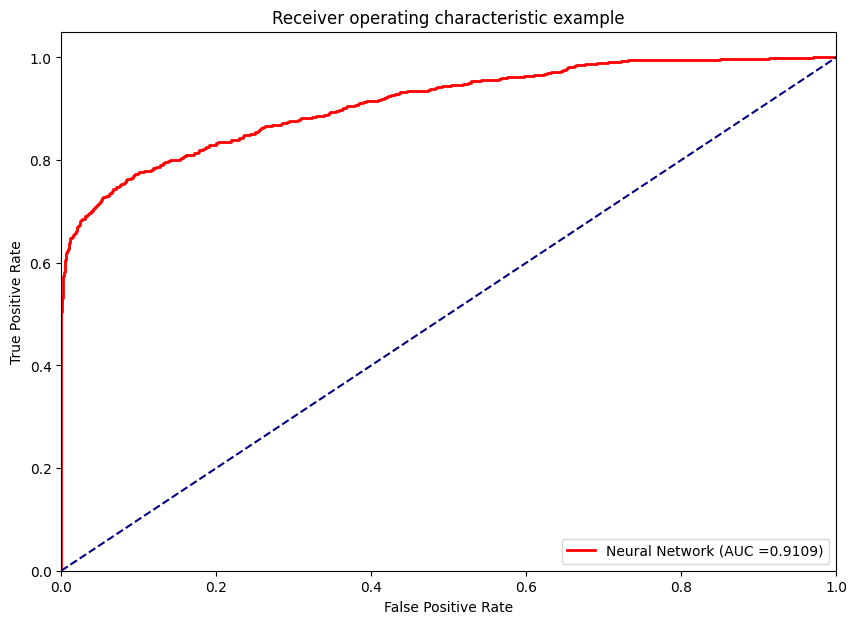

In [22]:
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)
y_pred_proba = model.predict(X_test)

ROC_Curve_plot(y_test,y_pred_proba,"Neural Network")

# Determining the loan grade

   person_age  person_income  person_home_ownership  person_emp_length  \
0   -0.908585      -0.122716                      3          28.433679   
1   -1.066912      -0.914701                      2           0.050477   
2   -0.433605      -0.914701                      0          -0.911665   
3   -0.750259      -0.018508                      3          -0.190059   
4   -0.591932      -0.196464                      3           0.772084   

   loan_intent  loan_amnt  loan_int_rate  loan_percent_income  \
0            4   4.003712       1.539799             3.951599   
1            1  -1.367966       0.029286            -0.653299   
2            3  -0.657009       0.564775             3.763644   
3            3   4.003712       1.295269             3.387734   
4            3   4.003712       0.998119             3.575689   

   cb_person_default_on_file  cb_person_cred_hist_length  
0                          1                   -0.692835  
1                          0                  

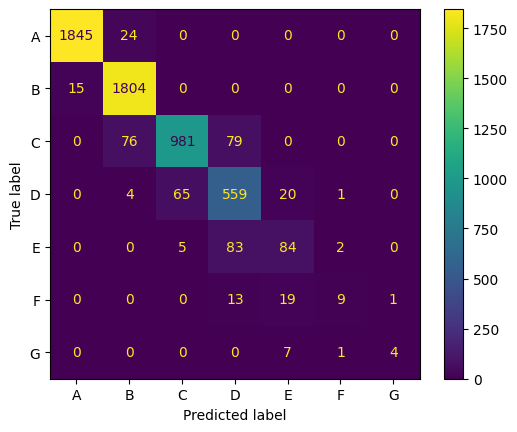

In [61]:
x = dtf.drop(columns=["loan_grade","loan_status"])
y = dtf["loan_grade"]

print(x.head())

X_train,X_test,y_train,y_test = train_test_split(x,y, test_size=0.2, stratify=y)

rf = RandomForestClassifier(random_state=42, n_estimators=300)

rf.fit(X_train,y_train)
y_pred =rf.predict(X_test)
y_pred_proba = []

Evaluate_metrics(y_test,y_pred,y_pred_proba,rf,mapped_grade)



In [ ]:
class_counts = y.value_counts()
scale_pos_weight = {cls: max (class_counts)/ count for cls, count in class_counts.items()}

xg = xgb.XGBClassifier(n_estimators=350, num_class=7, scale_pos_weight=scale_pos_weight,  objective="multi:softprob", eval_metric="aucpr", max_depth =7, subsample=0.9, colsample_bytree=0.9, learning_rate=0.045, random_state=42)

xg.fit(X_train,y_train)
y_pred = xg.predict(X_test)


Evaluate_metrics(y_test,y_pred,y_pred_proba,xg,mapped_grade)




SyntaxError: invalid syntax. Perhaps you forgot a comma? (3057768169.py, line 4)